# Predict Future Sales - Kaggle Competition
In this project, we take part in the Predict Future Sales competition. In this project we have to work with a  time-series dataset that consists of daily sales data. The data was provided by one of the largest Russian software firms - 1C Company. Given the daily historical sales data, the challenge is to forecast the total amount of products sold in every shop for the test set for the next month. 

The data itself requires quite a bit of cleaning and feature engineering to become usable to make accurate predictions. To make things more challenging, everything is in Russian. So understanding the data will be difficult. 

For the Kaggle Competetion, RMSE is the metric of choice for evaluation, so this is what we will use when training/testing. Let's go ahead and read in the data and get started.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import datetime as dt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor

In [2]:
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

We're given a few different datasets to help understand the data a bit more. Let's look at each one further.

In [3]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In the training set, we can see that there are almost 3 million entries and we're given a the date, shop, item, price, and the amount of items sold for each day. Using just this data, making predictions will be very hard. Luckily, we're given some additional datasets that can paint a better picture to each of these features. Hopefully we'll be able to feature engineer some helpful features to provide accurate predictions.

In [4]:
print(items.info())
items.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


For the <code>'items'</code> dataset, there are 22,170 items and each one has an <code>'item_id'</code> number as well as a <code>item_category_id</code> number.

In [5]:
print(item_cat.info())
item_cat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


The <code>'item_cat'</code> dataset links by the <code>'item_category_id'</code> number to give a name for the category. Here we can already see we'll be able to create some additional features by splitting the <code>'item_category_name'</code> into main categories and subcategories. For example, <code>'Аксессуары'</code> and <code>'PS2'</code>.

In [6]:
print(shops.info())
shops.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


The <code>'shops'</code> dataset gives a <code>'shop_name'</code> and <code>'shop_id'</code> that once we explore further, may be able to offer up some additional features. The <code>'shop_id'</code> links directly to the training set.

Now that we've become a bit familiar with all the data, let's explore the training and test set a bit further.

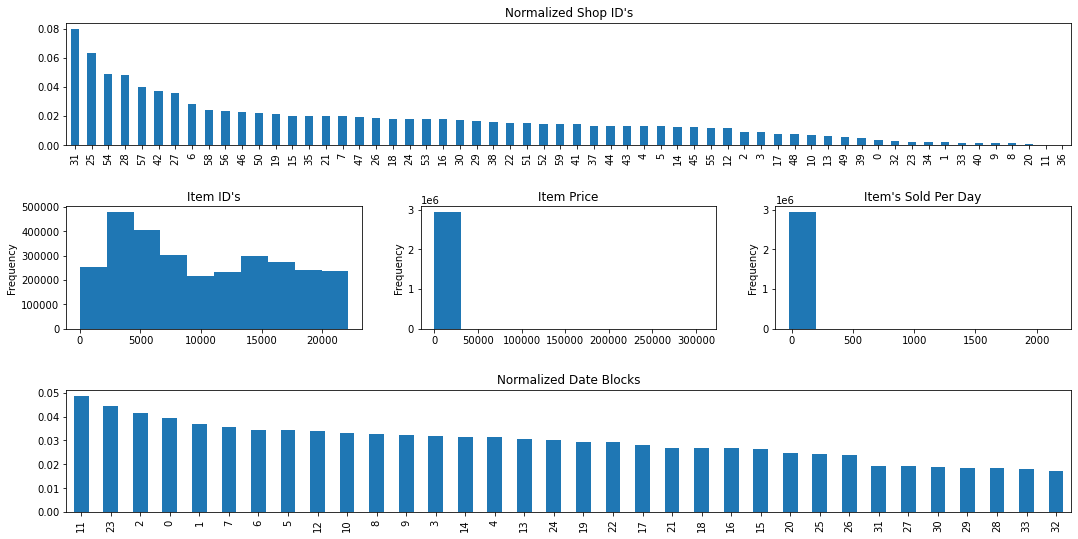

In [7]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train['shop_id'].value_counts(normalize=True).plot(kind='bar')
plt.title("Normalized Shop ID's")

plt.subplot2grid((3,3), (1,0))
train['item_id'].plot(kind='hist')
plt.title("Item ID's")

plt.subplot2grid((3,3), (1,1))
train['item_price'].plot(kind='hist')
plt.title('Item Price')

plt.subplot2grid((3,3), (1,2))
train['item_cnt_day'].plot(kind='hist')
plt.title("Item's Sold Per Day")

plt.subplot2grid((3,3), (2,0), colspan = 3)
train['date_block_num'].value_counts(normalize=True).plot(kind='bar')
plt.title('Normalized Date Blocks')

plt.show()

Looking at the distributions, we can see a lot of patterns and red flags. In terms of the Shop ID's, we can see that the frequency is heavily skewed towards a handful of shops and tapers off rather quickly. For Item ID's we can see some skewed distributions as well for ID's all around the 5000 range. For the Date, we can see that December is a hot month for sales (11 and 23). For both the Item Price and Item's Sold per day we can see with all the empty space, there must be some outliers that need to be addressed.

Before we dig into cleaning up the training set, let's visuzalize the test set as well.

In [8]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
None


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Here we can see that we're only given the <code>'shop_id'</code> and <code>'item_id'</code>. Let's visualize the data.

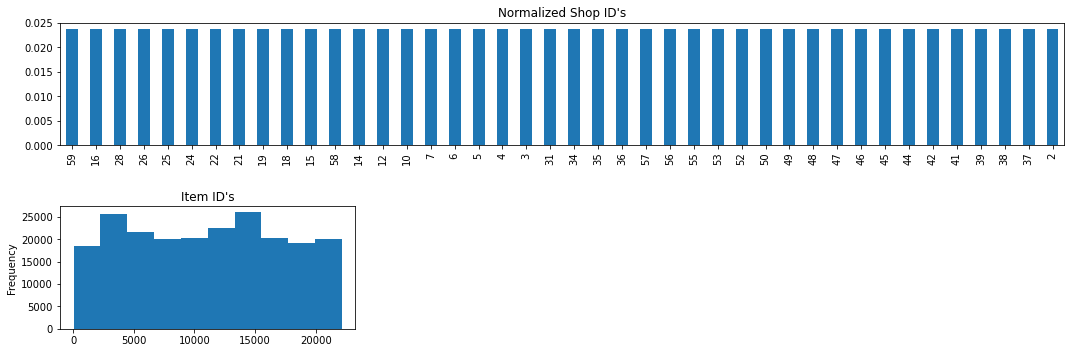

In [9]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar')
plt.title("Normalized Shop ID's")

plt.subplot2grid((3,3), (1,0))
test['item_id'].plot(kind='hist')
plt.title("Item ID's")

plt.show()

Right away we can see some pretty key differences. The Shop ID's are equally distributed amongst each shop and the Item Id's are also much more equally distributed. Looks like training the model to accurately predict on the test set will be difficult.

Let's begin analyzing the training set and see what cleaning and engineering we can do. Let's start with the <code>'item_price'</code>.

mean       890.853233
std       1729.799631
min         -1.000000
25%        249.000000
50%        399.000000
75%        999.000000
max     307980.000000
Name: item_price, dtype: float64


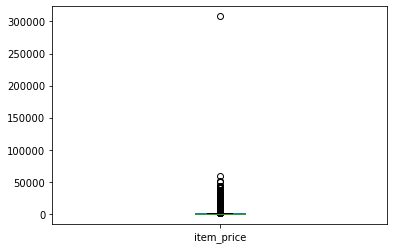

In [10]:
print(train.item_price.describe()[1:])
train.item_price.plot.box()

Here we can see that there are a couple of major outliers. We have one price that is 307980 which is way above the rest of the prices. Also there is a -1 price. Let's take a look at both of these.

In [11]:
train[train.item_price > 100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [12]:
items[items.item_id == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


If we use Google Translate, we're given "Radmin 3 - 522 people." Sounds like whatever Radmin was, it was sold to 522 people. This seems like an incorrect entry, so we can safely drop it.

In [13]:
train = train[train.item_price < 100000]

In [14]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [15]:
train[(train.item_id == 2973)].head()
print(train[(train.item_id == 2973)]['item_price'].mean())
print(train[(train.item_id == 2973)]['item_price'].value_counts().head())

2041.627277472527
2499.0    444
1249.5    124
1249.0     96
1901.0     28
1250.0     12
Name: item_price, dtype: int64


In [16]:
train[(train.item_id == 2973) & (train['date_block_num'] == 4)& (train['shop_id'] == 32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,-1.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


Looking at the -1 value, it seems to be a mistake. The average price is 2041 with the majority of values being 2499. For the exact shop selling that item, it's tough to say whether they meant to key in 1249 or 2499. The -1 value is a couple weeks before the 1249 price, and then in June, it looks like they increased the price to 2499. I'm going to assume this was originally listed at 1249.0.

In [17]:
train.loc[train['item_price'] == -1, 'item_price'] = 1249.0

In [18]:
train.item_price.describe()[1:]

mean      890.749059
std      1720.490066
min         0.070000
25%       249.000000
50%       399.000000
75%       999.000000
max     59200.000000
Name: item_price, dtype: float64

Looks like another high value, let's take a look.

In [19]:
train[train['item_price'] > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


In [20]:
train[train['item_id'] == 11365].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58283,09.01.2013,0,12,11365,1148.000000,5.0
58284,10.01.2013,0,12,11365,2235.000000,2.0
58285,14.01.2013,0,12,11365,1753.333333,3.0
58286,15.01.2013,0,12,11365,1435.000000,2.0
58287,16.01.2013,0,12,11365,1930.000000,1.0


In [21]:
train[train['item_id'] == 13199].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1488135,20.03.2014,14,25,13199,50999.0,1.0


Item 11365 has multiple sales and the price is nowhere near 59,200. We can safely drop this. The other item only has one sale, so we'll leave it.

In [22]:
train.drop(885138,axis=0, inplace=True)

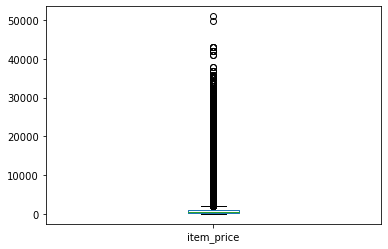

In [23]:
train.item_price.plot.box()

In [24]:
train[train['item_price'] > 40000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1006638,24.10.2013,9,12,7238,42000.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0
2143903,20.11.2014,22,12,14173,40900.0,1.0
2327159,29.01.2015,24,12,7241,49782.0,1.0
2885692,23.10.2015,33,42,13403,42990.0,1.0
2893100,20.10.2015,33,38,13403,41990.0,1.0
2910155,20.10.2015,33,12,13403,41990.0,1.0
2910156,29.10.2015,33,12,13403,42990.0,1.0
2913267,22.10.2015,33,18,13403,41990.0,1.0
2917760,20.10.2015,33,3,13403,42990.0,1.0


In [25]:
train[train['item_id'] == 7238]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1006638,24.10.2013,9,12,7238,42000.0,1.0


In [26]:
train[train['item_id'] == 7241]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2327159,29.01.2015,24,12,7241,49782.0,1.0


In [27]:
train[train['item_id'] == 14173]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2143903,20.11.2014,22,12,14173,40900.0,1.0


Looks like our we've cleaned up all the <code>'item_price'</code> values to remove the extreme outliers. Let's move on to <code>'item_id'</code>.

In [28]:
train.item_id.value_counts(ascending=False).head()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

Looks like there is an item that was sold 31340 times, way above the rest. Let's explore further.

In [29]:
items[items.item_id == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


Using Google images, with the item_name, it looks like a plastic bag. This is probably an accurate amount of sales and we can leave it in.

Let's move on to <code>'item_cnt_day'</code>

In [30]:
train.item_cnt_day.describe()[1:]

mean       1.242641
std        2.618835
min      -22.000000
25%        1.000000
50%        1.000000
75%        1.000000
max     2169.000000
Name: item_cnt_day, dtype: float64

There seems to be an item that was sold 2169 times. This seems incredibly high and not in line with the rest of the distributions. Let's take a look.

In [31]:
train[train['item_cnt_day'] == 2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [32]:
train[train['item_id'] == 11373]['item_cnt_day'].value_counts(ascending=False).head()

1.0    93
2.0    70
3.0    47
4.0    44
6.0    34
Name: item_cnt_day, dtype: int64

Looks like the standard amount of sales of that item is way less. We can safely drop it.

There were some negative sales, which I assume would be returns, but let's explore a bit further

In [33]:
train.drop(2909818, axis = 0, inplace=True)

In [34]:
train[train['item_cnt_day'] < 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7356 entries, 2 to 2935779
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            7356 non-null   object 
 1   date_block_num  7356 non-null   int64  
 2   shop_id         7356 non-null   int64  
 3   item_id         7356 non-null   int64  
 4   item_price      7356 non-null   float64
 5   item_cnt_day    7356 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 402.3+ KB


In [35]:
train[train['item_cnt_day'] < -10]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1057907,02.11.2013,10,12,8023,15.0,-22.0
1835454,10.07.2014,18,14,20949,5.0,-16.0


In [36]:
train[train['item_id'] == 20949].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,30.04.2013,3,22,20949,5.000000,12.0
352399,29.04.2013,3,22,20949,4.923077,13.0
352400,28.04.2013,3,22,20949,5.000000,4.0
352401,27.04.2013,3,22,20949,5.000000,4.0
352455,24.04.2013,3,22,20949,5.000000,2.0


In [37]:
train[train['item_id'] == 8023].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
8820,04.01.2013,0,22,8023,20.0,1.0
11064,02.01.2013,0,19,8023,20.0,1.0
11065,03.01.2013,0,19,8023,20.0,1.0
11066,06.01.2013,0,19,8023,20.0,1.0
15486,02.01.2013,0,28,8023,20.0,1.0


Ultimately there are over 7000 days that incurred these returns, only a couple of returns on the day that were more than -10. Not sure if that is accurate or not, but since it doesn't happyen often, we can safely drop these.

In [38]:
train.drop(1057907, axis = 0, inplace=True)
train.drop(1835454, axis = 0, inplace=True)

Now that we have safely dealt with some major outliers, let's begin exploring the items and shops to see if we can create and then link to the training set some more features via feature engineering. Let's take a look at the item categories since we saw some initial opportunities there.

In [39]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


The word <code>'Аксессуары'</code> translates to Accessories and PS2, PS3, etc. are all consoles. We can split all of these into main and sub categories and then label encode them so they have ID numbers.

In [40]:
item_cat['main_cat'] = item_cat['item_category_name'].str.split('-').str[0]
item_cat['sub_cat'] = item_cat['item_category_name'].str.split('-').str[1]
item_cat['sub_cat'].fillna(item_cat['main_cat'],inplace=True)

le = LabelEncoder()
item_cat['main_cat'] = le.fit_transform(item_cat['main_cat'])
item_cat['sub_cat'] = le.fit_transform(item_cat['sub_cat'])

Let's take a look at the <code>'shops'</code> now. 

In [41]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


If we Google search <code>'Якутск'</code>, it looks to be a city. It seems the shop names all begin with cities. We can extract that out and create a city ID number. For <code>'Якутск'</code>, there are a couple of shop names with and <code>'!'</code> before hand, so we'll have to fix that.

In [42]:
shops['city'] = shops['shop_name'].str.split(' ').str[0]
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'
shops['city'] = le.fit_transform(shops['city'])

In [43]:
shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,29
1,"!Якутск ТЦ ""Центральный"" фран",1,29
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2
5,"Вологда ТРЦ ""Мармелад""",5,3
6,"Воронеж (Плехановская, 13)",6,4
7,"Воронеж ТРЦ ""Максимир""",7,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,4
9,Выездная Торговля,9,5


Looking through the names, there seems to be some very similar names, exploring further, they are the same. We should drop the duplicates from the training and test sets.

In [44]:
train.loc[train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

train.loc[train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

train.loc[train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

Before we get started with merging our datasets, let's double check there are no duplicates in the training set.

In [45]:
train[train.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.0,1.0
76962,05.01.2013,0,54,20130,149.0,1.0
1435365,23.02.2014,13,50,3423,999.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496765,23.03.2014,14,21,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671872,01.05.2014,16,50,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866322,12.07.2014,18,25,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0


Looks like we have a few duplicates, let's drop the duplicates and keep the first value.

In [46]:
train.drop_duplicates(inplace=True)

Now that we have everything cleaned, let's begin merging all the datasets together.

In [47]:
#create a new shop dataset
new_shops = shops[['shop_id','city']]

#create a new item dataset
new_item_cats = item_cat[['item_category_id','main_cat','sub_cat']]

#create a new training set
new_train = train[['date_block_num','shop_id','item_id','item_price','item_cnt_day']]

#create monthly item sales and clip 0 to 20
new_train = new_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

#create a new test set and add the date
new_test = test.copy()
new_test['date_block_num'] = 34

#append test to training set so we can add in additional features
new_train = new_train.append(new_test.drop('ID', axis = 1))

#merge in all datasets
new_train = pd.merge(new_train, new_shops, on=['shop_id'], how='left')
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train = pd.merge(new_train, new_item_cats, on=['item_category_id'], how='left')

new_train.sort_values('date_block_num').tail()

,shop_id,item_id,date_block_num,item_cnt_month,city,item_category_id,main_cat,sub_cat
1680525,21,5232,34,NaN,13,23,5,16
1680526,21,5268,34,NaN,13,20,5,11
1680527,21,5039,34,NaN,13,23,5,16
1680555,21,5672,34,NaN,13,3,1,11
1823321,45,969,34,NaN,20,37,11,1


Now that we have all the datasets merged together and the test set added under the date of 34, we can being the additional feature engineering that will help our algorithms learn more efficiently. Since this is a time series dataset and price changes over time. Adding in monthly time lag to the data can prove very helpful. Let's add the lagged features and trend features in.

In [48]:
def generate_lag(train, months, lag_column):
    for month in months:
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].shift(month)
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

#Lag Monthly Target Sales
new_train = generate_lag(new_train, [1,2,3,4,5,6,12], 'item_cnt_month')

#Lag Monthly Item and Target Mean
group = new_train.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'item_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'item_month_mean')
new_train.drop(['item_month_mean'], axis=1, inplace=True)

#Lag Monthly Shop and Target Mean
group = new_train.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'shop_month_mean')
new_train.drop(['shop_month_mean'], axis=1, inplace=True)

#Lag Monthly Shop and Item Category Mean
group = new_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_train = generate_lag(new_train, [1, 2], 'shop_category_month_mean')
new_train.drop(['shop_category_month_mean'], axis=1, inplace=True)

#Lag Monthly Item Main Category Mean
group = new_train.groupby(['date_block_num', 'main_cat'])['item_cnt_month'].mean().rename('main_cat_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'main_cat'], how='left')

new_train = generate_lag(new_train, [1], 'main_cat_month_mean')
new_train.drop(['main_cat_month_mean'], axis=1, inplace=True)

#Lag Monthly Sub Category Mean
group = new_train.groupby(['date_block_num', 'sub_cat'])['item_cnt_month'].mean().rename('sub_cat_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'sub_cat'], how='left')

new_train = generate_lag(new_train, [1], 'sub_cat_month_mean')
new_train.drop(['sub_cat_month_mean'], axis=1, inplace=True)

#Lag Montly Target Mean
group = new_train.groupby(['date_block_num'])['item_cnt_month'].mean().rename('date_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num'],how='left')
new_train = generate_lag(new_train,[1],'date_month_mean')
new_train.drop(['date_month_mean'], axis = 1, inplace=True)

#Lag Monthly Item Category Mean
group = new_train.groupby(['date_block_num','item_category_id'])['item_cnt_month'].mean().rename('date_item_cat_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num','item_category_id'],how='left')
new_train = generate_lag(new_train,[1],'date_item_cat_month_mean')
new_train.drop(['date_item_cat_month_mean'], axis = 1, inplace=True)

#Lag Monthly Shop and Main Category Mean
group = new_train.groupby(['date_block_num','shop_id','main_cat'])['item_cnt_month'].mean().rename('date_shop_main_cat_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num','shop_id','main_cat'],how='left')
new_train = generate_lag(new_train,[1],'date_shop_main_cat_month_mean')
new_train.drop(['date_shop_main_cat_month_mean'], axis = 1, inplace=True)

#Lag Monthly Shop and Sub Category Mean
group = new_train.groupby(['date_block_num','shop_id','sub_cat'])['item_cnt_month'].mean().rename('date_shop_sub_cat_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num','shop_id','sub_cat'],how='left')
new_train = generate_lag(new_train,[1],'date_shop_sub_cat_month_mean')
new_train.drop(['date_shop_sub_cat_month_mean'], axis = 1, inplace=True)

#Lag Monthly City ID Mean
group = new_train.groupby(['date_block_num','city'])['item_cnt_month'].mean().rename('date_city_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num','city'],how='left')
new_train = generate_lag(new_train,[1],'date_city_month_mean')
new_train.drop(['date_city_month_mean'], axis = 1, inplace=True)

#Lag Monthly Item by City ID Mean
group = new_train.groupby(['date_block_num','item_id','city'])['item_cnt_month'].mean().rename('date_city_item_month_mean').reset_index()
new_train = pd.merge(new_train,group, on=['date_block_num','item_id','city'],how='left')
new_train = generate_lag(new_train,[1],'date_city_item_month_mean')
new_train.drop(['date_city_item_month_mean'], axis = 1, inplace=True)

#Add Months
new_train['month'] = new_train['date_block_num'] % 12

# Price trend last 6 months
group = train.groupby(['item_id'])['item_price'].mean().rename('item_mean_item_price').reset_index()
new_train = pd.merge(new_train, group, on=['item_id'], how='left')

group = train.groupby(['date_block_num','item_id'])['item_price'].mean().rename('date_item_mean_item_price').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
new_train = generate_lag(new_train, lags, 'date_item_mean_item_price')

for i in lags:
    new_train['price_trend_lag_'+str(i)] = (new_train['date_item_mean_item_price_lag_'+str(i)
                                                     ] - new_train['item_mean_item_price'
                                                                  ]) / new_train['item_mean_item_price']
def select_trend(row):
    for i in lags:
        if row['price_trend_lag_'+str(i)]:
            return row['price_trend_lag_'+str(i)]
    return 0
    
new_train['price_trend_lag'] = new_train.apply(select_trend, axis=1)
new_train['price_trend_lag'].fillna(0, inplace=True)

features_to_drop = ['item_mean_item_price', 'date_item_mean_item_price']
for i in lags:
    features_to_drop += ['date_item_mean_item_price_lag_'+str(i)]
    features_to_drop += ['price_trend_lag_'+str(i)]

new_train.drop(features_to_drop, axis=1, inplace=True)

#Months Since First Sale
new_train['item_first_sale'] = new_train['date_block_num'] - new_train.groupby(
    'item_id')['date_block_num'].transform('min')

When working with time series datasets and adding lagged features, we'll be left with a lot of NaN values, so we'll need to fill those with 0's.

In [49]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

new_train = fill_na(new_train)

Due to the fact that the dataset has almost 3 million entries and now a bunch of features added, downcasting the values to a lower data type will help reduce memory overload.

In [50]:
def downcast(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]

    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [51]:
new_train = downcast(new_train)

Now that we have all the new features engineered and added to the training set, let's take a look at the new training set and begin running some machine learning algorithms on the training set with leaving off the test set.

In [52]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,city,item_category_id,main_cat,sub_cat,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,item_month_mean_lag_1,item_month_mean_lag_2,item_month_mean_lag_3,item_month_mean_lag_6,item_month_mean_lag_12,shop_month_mean_lag_1,shop_month_mean_lag_2,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_cat_month_mean_lag_1,sub_cat_month_mean_lag_1,date_month_mean_lag_1,date_item_cat_month_mean_lag_1,date_shop_main_cat_month_mean_lag_1,date_shop_sub_cat_month_mean_lag_1,date_city_month_mean_lag_1,date_city_item_month_mean_lag_1,month,price_trend_lag,item_first_sale
0,2,27,0,1.0,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
1,2,27,17,1.0,0,19,5,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,17
2,2,30,2,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1
3,2,30,5,1.0,0,40,11,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.859375,0.0,0.0,0.0,0.0,1.754883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,4
4,2,30,15,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,14


In [53]:
#Due to the 12 month lags added, drop first 12 months
new_train = new_train[new_train['date_block_num']>11]

#remove test set
final_train = new_train[new_train['date_block_num']<34]

We'll begin by doing a simple 75/25 split on the training data and run a KNN model with 11 neighbors to get an idea of how well a simple model will perform.

In [54]:
features = list(final_train.drop('item_cnt_month',axis=1).columns)

target = 'item_cnt_month'
X_train, X_test, y_train, y_test = train_test_split(final_train[features], final_train[target]
                                                    , test_size = 0.25, random_state = 1, shuffle=True)

In [55]:
knn = KNeighborsRegressor(n_neighbors = 11)
knn.fit(X_train,y_train)
train_predictions = knn.predict(X_train)
test_predictions = knn.predict(X_test)

train_knn_mse = mean_squared_error(y_train, train_predictions)
train_knn_rmse = np.sqrt(train_knn_mse)

test_knn_mse = mean_squared_error(y_test, test_predictions)
test_knn_rmse = np.sqrt(test_knn_mse)

print(train_knn_rmse)

print(test_knn_rmse)

1.573
1.729


With an RMSE score of 1.5 on the Training set and 1.7 on the Test set, that's a relatively good score. Due to the large dataset, a grid search on a Random Forest is not feasible. I already ran multiple options and below is the best tuned model I came up with. Ideally I would also run a KFold Cross Validation, but due to the large datasets, it would be too time consuming.

In [56]:
rf = RandomForestRegressor(n_estimators = 500, max_depth = None, max_features = 'sqrt',
                           min_samples_leaf = 1, min_samples_split = 5)
rf.fit(X_train,y_train)
train_predictions = rf.predict(X_train)
test_predictions = rf.predict(X_test)

train_rf_mse = mean_squared_error(y_train, train_predictions)
train_rf_rmse = np.sqrt(train_rf_mse)

test_rf_mse = mean_squared_error(y_test, test_predictions)
test_rf_rmse = np.sqrt(test_rf_mse)

print('Training Set RMSE: ',train_rf_rmse)

print('Testing Set RMSE: ',test_rf_rmse)

imp = rf.feature_importances_
cols = list(features)
imp_df = pd.DataFrame({"feature": cols, "Importance": imp})
imp_sorted = imp_df.sort_values("Importance", ascending=False)
print('-'*50)
print(imp_sorted)

Training Set RMSE:  0.8574286291273118
Testing Set RMSE:  1.5612377005318108
--------------------------------------------------
                                feature  Importance
7                  item_cnt_month_lag_1    0.119042
1                               item_id    0.093955
33      date_city_item_month_mean_lag_1    0.076488
36                      item_first_sale    0.066065
14                item_month_mean_lag_1    0.062942
0                               shop_id    0.043911
8                  item_cnt_month_lag_2    0.043295
24       shop_category_month_mean_lag_1    0.033339
31   date_shop_sub_cat_month_mean_lag_1    0.032705
4                      item_category_id    0.029028
34                                month    0.027765
3                                  city    0.027287
2                        date_block_num    0.025894
6                               sub_cat    0.022855
9                  item_cnt_month_lag_3    0.022250
30  date_shop_main_cat_month_mean_lag_1 

The Random Forest has gotten us better results than the KNN model with a score of 1.56 on the test set. Also, we can see that the top 5 most important features are all engineered but one. Let's submit the predictions for the holdout set to Kaggle to see our final score.

In [57]:
def save_submission_file(model,df,filename='submission.csv'):
    predictions = model.predict(df).clip(0,20)
    
    submission = pd.DataFrame({'ID':test.index,
                                 'item_cnt_month':predictions})
    submission.to_csv(filename,index=False)

In [58]:
X_final_train = new_train[new_train.date_block_num < 34].drop(['item_cnt_month'], axis=1)
y_final_train = new_train[new_train.date_block_num < 34]['item_cnt_month']
holdout = new_train[new_train['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

In [59]:
rf = RandomForestRegressor(n_estimators = 500, max_depth = None, max_features = 'sqrt',
                           min_samples_leaf = 1, min_samples_split = 5)
rf.fit(X_final_train,y_final_train)

save_submission_file(rf,holdout,filename='rf_submission.csv')

The final score once submiteed to Kaggle with the Random Forest Algorithm was 1.53. Pretty good! Let's try XGBoost.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(final_train[features], final_train[target]
                                                    , test_size = 0.25, random_state = 1, shuffle=True)

xgb = XGBRegressor(max_depth=None, n_estimators=1000, min_child_weight=300, colsample_bytree=0.8, 
    subsample = 0.8, learning_rate = 0.3, seed=1)

xgb.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, early_stopping_rounds = 10)

[0]	validation_0-rmse:2.48690	validation_1-rmse:2.46915
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.20377	validation_1-rmse:2.18810
[2]	validation_0-rmse:2.05798	validation_1-rmse:2.04411
[3]	validation_0-rmse:1.96185	validation_1-rmse:1.95043
[4]	validation_0-rmse:1.90567	validation_1-rmse:1.89534
[5]	validation_0-rmse:1.87158	validation_1-rmse:1.86266
[6]	validation_0-rmse:1.84664	validation_1-rmse:1.83920
[7]	validation_0-rmse:1.83398	validation_1-rmse:1.82764
[8]	validation_0-rmse:1.82301	validation_1-rmse:1.81729
[9]	validation_0-rmse:1.81524	validation_1-rmse:1.81080
[10]	validation_0-rmse:1.80900	validation_1-rmse:1.80526
[11]	validation_0-rmse:1.80509	validation_1-rmse:1.80162
[12]	validation_0-rmse:1.80221	validation_1-rmse:1.79942
[13]	validation_0-rmse:1.79410	validation_1-rmse:1.79221
[14]	validation_0-rmse:1.79152	validation_1-rmse:1.78

[141]	validation_0-rmse:1.65146	validation_1-rmse:1.68340
[142]	validation_0-rmse:1.65055	validation_1-rmse:1.68295
[143]	validation_0-rmse:1.64997	validation_1-rmse:1.68256
[144]	validation_0-rmse:1.64966	validation_1-rmse:1.68243
[145]	validation_0-rmse:1.64946	validation_1-rmse:1.68219
[146]	validation_0-rmse:1.64928	validation_1-rmse:1.68216
[147]	validation_0-rmse:1.64914	validation_1-rmse:1.68210
[148]	validation_0-rmse:1.64732	validation_1-rmse:1.68063
[149]	validation_0-rmse:1.64693	validation_1-rmse:1.68064
[150]	validation_0-rmse:1.64634	validation_1-rmse:1.68019
[151]	validation_0-rmse:1.64601	validation_1-rmse:1.67993
[152]	validation_0-rmse:1.64575	validation_1-rmse:1.67981
[153]	validation_0-rmse:1.64571	validation_1-rmse:1.67980
[154]	validation_0-rmse:1.64536	validation_1-rmse:1.67958
[155]	validation_0-rmse:1.64318	validation_1-rmse:1.67729
[156]	validation_0-rmse:1.64303	validation_1-rmse:1.67720
[157]	validation_0-rmse:1.64258	validation_1-rmse:1.67693
[158]	validati

[283]	validation_0-rmse:1.59216	validation_1-rmse:1.64812
[284]	validation_0-rmse:1.59139	validation_1-rmse:1.64756
[285]	validation_0-rmse:1.59115	validation_1-rmse:1.64753
[286]	validation_0-rmse:1.59095	validation_1-rmse:1.64745
[287]	validation_0-rmse:1.59013	validation_1-rmse:1.64671
[288]	validation_0-rmse:1.59002	validation_1-rmse:1.64665
[289]	validation_0-rmse:1.58946	validation_1-rmse:1.64622
[290]	validation_0-rmse:1.58767	validation_1-rmse:1.64444
[291]	validation_0-rmse:1.58741	validation_1-rmse:1.64423
[292]	validation_0-rmse:1.58689	validation_1-rmse:1.64376
[293]	validation_0-rmse:1.58668	validation_1-rmse:1.64384
[294]	validation_0-rmse:1.58636	validation_1-rmse:1.64373
[295]	validation_0-rmse:1.58627	validation_1-rmse:1.64370
[296]	validation_0-rmse:1.58587	validation_1-rmse:1.64337
[297]	validation_0-rmse:1.58496	validation_1-rmse:1.64256
[298]	validation_0-rmse:1.58482	validation_1-rmse:1.64260
[299]	validation_0-rmse:1.58464	validation_1-rmse:1.64258
[300]	validati

[425]	validation_0-rmse:1.54953	validation_1-rmse:1.62519
[426]	validation_0-rmse:1.54929	validation_1-rmse:1.62519
[427]	validation_0-rmse:1.54912	validation_1-rmse:1.62512
[428]	validation_0-rmse:1.54866	validation_1-rmse:1.62493
[429]	validation_0-rmse:1.54856	validation_1-rmse:1.62492
[430]	validation_0-rmse:1.54823	validation_1-rmse:1.62492
[431]	validation_0-rmse:1.54738	validation_1-rmse:1.62425
[432]	validation_0-rmse:1.54661	validation_1-rmse:1.62368
[433]	validation_0-rmse:1.54656	validation_1-rmse:1.62365
[434]	validation_0-rmse:1.54652	validation_1-rmse:1.62372
[435]	validation_0-rmse:1.54612	validation_1-rmse:1.62340
[436]	validation_0-rmse:1.54600	validation_1-rmse:1.62340
[437]	validation_0-rmse:1.54556	validation_1-rmse:1.62302
[438]	validation_0-rmse:1.54529	validation_1-rmse:1.62291
[439]	validation_0-rmse:1.54526	validation_1-rmse:1.62288
[440]	validation_0-rmse:1.54511	validation_1-rmse:1.62282
[441]	validation_0-rmse:1.54504	validation_1-rmse:1.62279
[442]	validati

[567]	validation_0-rmse:1.51826	validation_1-rmse:1.61096
[568]	validation_0-rmse:1.51728	validation_1-rmse:1.61023
[569]	validation_0-rmse:1.51720	validation_1-rmse:1.61020
[570]	validation_0-rmse:1.51675	validation_1-rmse:1.60980
[571]	validation_0-rmse:1.51659	validation_1-rmse:1.60988
[572]	validation_0-rmse:1.51645	validation_1-rmse:1.60990
[573]	validation_0-rmse:1.51639	validation_1-rmse:1.60995
[574]	validation_0-rmse:1.51624	validation_1-rmse:1.60988
[575]	validation_0-rmse:1.51593	validation_1-rmse:1.60990
[576]	validation_0-rmse:1.51585	validation_1-rmse:1.60987
[577]	validation_0-rmse:1.51544	validation_1-rmse:1.60960
[578]	validation_0-rmse:1.51518	validation_1-rmse:1.60938
[579]	validation_0-rmse:1.51505	validation_1-rmse:1.60936
[580]	validation_0-rmse:1.51450	validation_1-rmse:1.60887
[581]	validation_0-rmse:1.51375	validation_1-rmse:1.60828
[582]	validation_0-rmse:1.51359	validation_1-rmse:1.60832
[583]	validation_0-rmse:1.51345	validation_1-rmse:1.60830
[584]	validati

[709]	validation_0-rmse:1.49043	validation_1-rmse:1.59880
[710]	validation_0-rmse:1.48970	validation_1-rmse:1.59827
[711]	validation_0-rmse:1.48960	validation_1-rmse:1.59825
[712]	validation_0-rmse:1.48928	validation_1-rmse:1.59823
[713]	validation_0-rmse:1.48922	validation_1-rmse:1.59823
[714]	validation_0-rmse:1.48921	validation_1-rmse:1.59820
[715]	validation_0-rmse:1.48910	validation_1-rmse:1.59815
[716]	validation_0-rmse:1.48906	validation_1-rmse:1.59816
[717]	validation_0-rmse:1.48899	validation_1-rmse:1.59816
[718]	validation_0-rmse:1.48891	validation_1-rmse:1.59813
[719]	validation_0-rmse:1.48882	validation_1-rmse:1.59815
[720]	validation_0-rmse:1.48874	validation_1-rmse:1.59812
[721]	validation_0-rmse:1.48871	validation_1-rmse:1.59816
[722]	validation_0-rmse:1.48862	validation_1-rmse:1.59813
[723]	validation_0-rmse:1.48847	validation_1-rmse:1.59808
[724]	validation_0-rmse:1.48840	validation_1-rmse:1.59807
[725]	validation_0-rmse:1.48826	validation_1-rmse:1.59807
[726]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

XGBoost got us a similar test RMSE score, with the best iteration being 1.58. Let's submit to Kaggle to see if it performs any better than the Random Forest.

In [61]:
xgb = XGBRegressor(max_depth=None, n_estimators=1000, min_child_weight=300, colsample_bytree=0.8, 
    subsample = 0.8, learning_rate = 0.3, seed=1)

xgb.fit(X_final_train,y_final_train, eval_metric="rmse", eval_set=[(X_final_train, y_final_train)], 
    verbose=True, early_stopping_rounds = 10)

save_submission_file(xgb,holdout,filename='xgb_submission.csv')

[0]	validation_0-rmse:2.48269
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.22263
[2]	validation_0-rmse:2.07707
[3]	validation_0-rmse:1.96989
[4]	validation_0-rmse:1.90391
[5]	validation_0-rmse:1.87617
[6]	validation_0-rmse:1.84771
[7]	validation_0-rmse:1.82896
[8]	validation_0-rmse:1.81721
[9]	validation_0-rmse:1.80502
[10]	validation_0-rmse:1.79939
[11]	validation_0-rmse:1.79371
[12]	validation_0-rmse:1.78813
[13]	validation_0-rmse:1.78384
[14]	validation_0-rmse:1.78070
[15]	validation_0-rmse:1.77687
[16]	validation_0-rmse:1.77140
[17]	validation_0-rmse:1.76899
[18]	validation_0-rmse:1.76444
[19]	validation_0-rmse:1.76331
[20]	validation_0-rmse:1.76133
[21]	validation_0-rmse:1.75849
[22]	validation_0-rmse:1.75694
[23]	validation_0-rmse:1.75255
[24]	validation_0-rmse:1.75150
[25]	validation_0-rmse:1.75012
[26]	validation_0-rmse:1.74945
[27]	validation_0-rmse:1.74809
[28]	validation_0-rmse:1.74631
[29]	validation_0-rmse:1.74393
[30]	validation

[258]	validation_0-rmse:1.58925
[259]	validation_0-rmse:1.58511
[260]	validation_0-rmse:1.58380
[261]	validation_0-rmse:1.58362
[262]	validation_0-rmse:1.58310
[263]	validation_0-rmse:1.58304
[264]	validation_0-rmse:1.58283
[265]	validation_0-rmse:1.58264
[266]	validation_0-rmse:1.58193
[267]	validation_0-rmse:1.58191
[268]	validation_0-rmse:1.58160
[269]	validation_0-rmse:1.58006
[270]	validation_0-rmse:1.57981
[271]	validation_0-rmse:1.57902
[272]	validation_0-rmse:1.57837
[273]	validation_0-rmse:1.57794
[274]	validation_0-rmse:1.57761
[275]	validation_0-rmse:1.57734
[276]	validation_0-rmse:1.57681
[277]	validation_0-rmse:1.57670
[278]	validation_0-rmse:1.57661
[279]	validation_0-rmse:1.57645
[280]	validation_0-rmse:1.57622
[281]	validation_0-rmse:1.57615
[282]	validation_0-rmse:1.57597
[283]	validation_0-rmse:1.57570
[284]	validation_0-rmse:1.57562
[285]	validation_0-rmse:1.57554
[286]	validation_0-rmse:1.57549
[287]	validation_0-rmse:1.57541
[288]	validation_0-rmse:1.57533
[289]	va

[515]	validation_0-rmse:1.52397
[516]	validation_0-rmse:1.52390
[517]	validation_0-rmse:1.52360
[518]	validation_0-rmse:1.52290
[519]	validation_0-rmse:1.52265
[520]	validation_0-rmse:1.52246
[521]	validation_0-rmse:1.52229
[522]	validation_0-rmse:1.52221
[523]	validation_0-rmse:1.52207
[524]	validation_0-rmse:1.52195
[525]	validation_0-rmse:1.52189
[526]	validation_0-rmse:1.52173
[527]	validation_0-rmse:1.52161
[528]	validation_0-rmse:1.52152
[529]	validation_0-rmse:1.52142
[530]	validation_0-rmse:1.52135
[531]	validation_0-rmse:1.52127
[532]	validation_0-rmse:1.52119
[533]	validation_0-rmse:1.52107
[534]	validation_0-rmse:1.52089
[535]	validation_0-rmse:1.52081
[536]	validation_0-rmse:1.52055
[537]	validation_0-rmse:1.52044
[538]	validation_0-rmse:1.52023
[539]	validation_0-rmse:1.52020
[540]	validation_0-rmse:1.52014
[541]	validation_0-rmse:1.52005
[542]	validation_0-rmse:1.51986
[543]	validation_0-rmse:1.51960
[544]	validation_0-rmse:1.51957
[545]	validation_0-rmse:1.51940
[546]	va

[772]	validation_0-rmse:1.47917
[773]	validation_0-rmse:1.47911
[774]	validation_0-rmse:1.47899
[775]	validation_0-rmse:1.47883
[776]	validation_0-rmse:1.47859
[777]	validation_0-rmse:1.47843
[778]	validation_0-rmse:1.47840
[779]	validation_0-rmse:1.47828
[780]	validation_0-rmse:1.47817
[781]	validation_0-rmse:1.47815
[782]	validation_0-rmse:1.47802
[783]	validation_0-rmse:1.47795
[784]	validation_0-rmse:1.47776
[785]	validation_0-rmse:1.47760
[786]	validation_0-rmse:1.47757
[787]	validation_0-rmse:1.47711
[788]	validation_0-rmse:1.47706
[789]	validation_0-rmse:1.47702
[790]	validation_0-rmse:1.47694
[791]	validation_0-rmse:1.47676
[792]	validation_0-rmse:1.47672
[793]	validation_0-rmse:1.47663
[794]	validation_0-rmse:1.47655
[795]	validation_0-rmse:1.47649
[796]	validation_0-rmse:1.47633
[797]	validation_0-rmse:1.47625
[798]	validation_0-rmse:1.47618
[799]	validation_0-rmse:1.47614
[800]	validation_0-rmse:1.47608
[801]	validation_0-rmse:1.47599
[802]	validation_0-rmse:1.47582
[803]	va

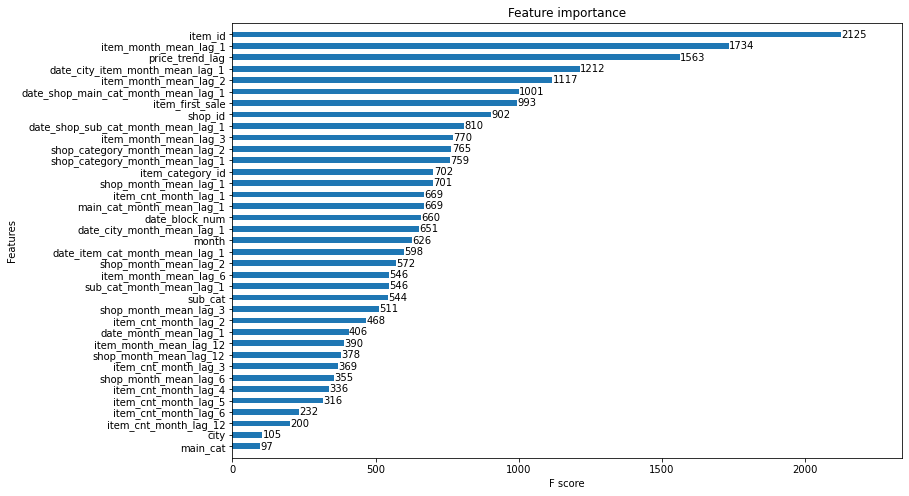

In [62]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_importance(xgb, ax = ax, height = .5)
ax.grid(False)

### Conclusion
XGBoost got us a final score with Kaggle of 1.47. Not bad! We can also see that the top feature importance is similar to the Random Forest, but not the same. 

We'll have to continue feature engineering and hyperparameter tuning our models to get closer to the top 10 leaderboard with scores of RMSE around .75.